# Template fitting

Template fitting method calculates the amplitude, phase and zero point variation of a modulate time series by fitting a template composed of Fourier harmonics.

The method works as follows:

- First, using `seismolab.fourier`, it calculates a Lomb-Scargle spectrum and derives the frequency of the main peak in spectrum
- Also derives the harmonics of the main peak
- Then, creates a template using this series of Fourier harmonics 
- Splits the light curve into overlapping chunks, the lengths are specified proportion to the main period
- And fits the template to each chunk to yield the amplitude, phase and zero point at each time step

## __How to use__

In [1]:
from seismolab.template import TemplateFitter

import numpy as np
import matplotlib.pyplot as plt

We load as an example the Blazhko modulated light curve of T Men from TESS Setor 1.

In [2]:
lc = np.loadtxt("https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:HLSP/qlp/s0001/0000/0000/4041/2372/hlsp_qlp_tess_ffi_s0001-0000000040412372_tess_v01_llc.txt", delimiter=',').T

# Store results in separate arrays for clarity
time       = lc[0]
brightness = lc[1]
brightness_error = np.ones_like(time)*0.01

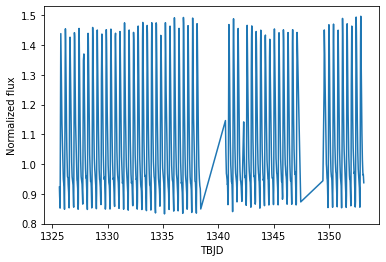

In [3]:
plt.plot(time, brightness)
plt.xlabel("TBJD")
plt.ylabel("Normalized flux")
plt.show()

### Performing a template fitting

We initialize the `TemplateFitter` by passing the light curve. Passing the measurement errors is optional, but without it the estimated errors will be unrealistic!

In [4]:
fitter = TemplateFitter(time, brightness, brightness_error)

The template fitting is done by calling `fit`.

0it [00:00, ?it/s]

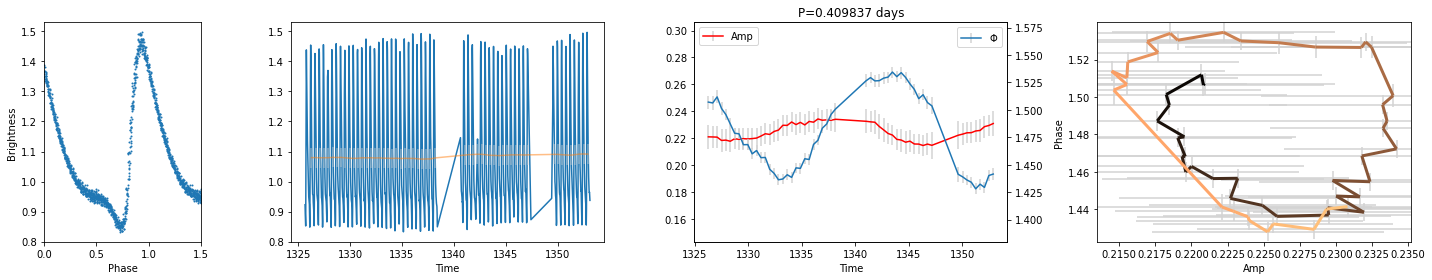

In [5]:
times, amp, amperr, phase, phaseerr, zp, zperr = fitter.fit(plotting=True,scale='flux')

The results and its errors are stored in seven arrays:

- `times` is the equidistant time steps,
- `amp` & `amperr` are the temporal variation of the amplitude of the template and its uncertainty,
- `phase` & `phaseerr` are the temporal variation of the phase of the template and its uncertainty,
- `zp` & `zperr` are the temporal variation of the zero point of the template and its uncertainty.

All available options are described below:

0it [00:00, ?it/s]

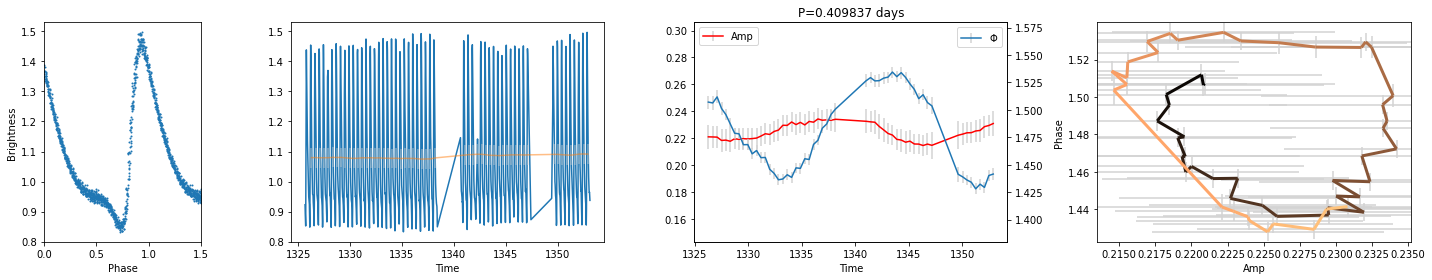

In [6]:
times, amp, amperr, phase, phaseerr, zp, zperr = fitter.fit(
        span = 3,                    # Number of (pulsation) cycles to be fitted
        step = 1,                    # Steps in number of (pulsation) cycles
        error_estimation='analytic', # Can be `analytic` or `montecarlo`

        maxharmonics = 10,       # Max number of Fourier harmonics to be used in the template
        minimum_frequency=None,
        maximum_frequency=None,  # Overwrites nyquist_factor!
        nyquist_factor=1,        # The multiple of the average nyquist frequency
        samples_per_peak=100,    # Oversampling factor in Lomb-Scargle spectrum calculation
        kind='sin',              # Function type: `sin` or `cos`

        plotting=True,           # Show results
        scale='flux',            # Light curve scale, `mag` or `flux`
        saveplot=False,          # Save the plot as file
        saveresult=False,        # Save result as txt file
        filename = 'mystar',     # Without extension
        showerrorbar=True,       # Show errorbars in plots
    
        smoothness_factor=0.5,   # Smooth the curves by a Gaussian (0: None, 1-: strong smoothing)
        duty_cycle=0.6,          # Skip cycles if duty cycle is lower than this value (between 0-1)

        best_freq=None,          # Use this frequency for the basis of the Fourier harmonics
                                 # This option overwrites the automatic Lomb-Scargle frequency search
        
        debug=False              # Verbose output
    )

### Constructing the modulated template light curve

To visualize the modulation of the template curve, it is suggested to calculate a well-sampled modulate curve first. To do, the steps in number of (pulsation) cycles is reduced, i.e. the sampling grid is refined.

In [7]:
times, amp, amperr, phase, phaseerr, zp, zperr = fitter.fit(
        span = 3,                    # Number of (pulsation) cycles to be fitted
        step = 0.01,                 # Steps in number of (pulsation) cycles
    )

0it [00:00, ?it/s]

Then the well-sampled modulated template curve is constructed.

In [8]:
template = fitter.get_lc_model()

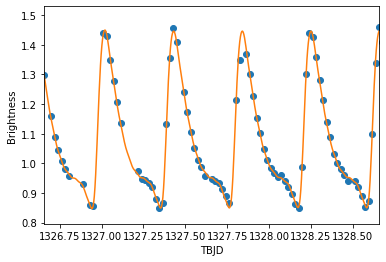

In [9]:
plt.plot( time, brightness,'o' )
plt.plot( times, template )
plt.xlim(time.min()+1,time.min()+3)
plt.xlabel("TBJD")
plt.ylabel("Brightness")
plt.show()

__Resampling the template curve__

Since the modulated template curve is sampled on a uniform grid, it is ought to be resampled at the time steps of the original light curve to e.g. get the residual light curve.

The resampled template curve can be easily constracted using an interpolation method.

In [10]:
template = fitter.get_lc_model_interp(kind='slinear')

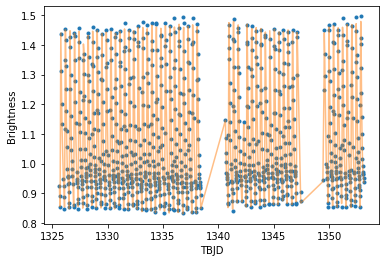

In [11]:
plt.plot(time,brightness,'.')
plt.plot(time,template,alpha=0.5 )
plt.xlabel("TBJD")
plt.ylabel("Brightness")
plt.show()

This template curve can be subtracted from the original light curve.

In [12]:
residual = brightness - template

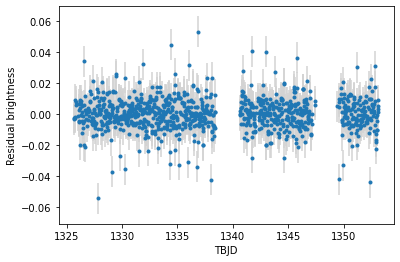

In [13]:
plt.errorbar(time, residual, brightness_error, fmt='.', ecolor='lightgray' )
plt.xlabel("TBJD")
plt.ylabel("Residual brightness")
plt.show()

### Comparing the spectra

To see the effect of subtracting the modulted template curve from the original light curve, one way is to compare the Fourier spectra of these data sets. Here, we also compare the results to the residual light curve, which is obtained by subtracting the sum of Fourier harmonics from the original observations.

In [14]:
from astropy.timeseries import LombScargle
from seismolab.fourier import MultiHarmonicFitter

Using the `seismolab.fourier` a series of Fourier harmonics are fitted and subtracted.

In [15]:
fourier = MultiHarmonicFitter(time,brightness)

pfit,perr = fourier.fit_harmonics(maxharmonics=100)

time, resbrightness = fourier.get_residual()

The Lomb-Scargle spectrum of each light curve is calculated.

In [16]:
lsf,lsp = LombScargle(time,brightness).autopower(nyquist_factor=1,
                                                 normalization='psd')
lsp_res      = LombScargle(time,resbrightness).power(lsf,normalization='psd')
lsp_template = LombScargle(time,residual).power(lsf,normalization='psd')

And transform to Fourier-like spectra.

In [17]:
lsp          = 2*np.sqrt(lsp/len(time))
lsp_res      = 2*np.sqrt(lsp_res/len(time))
lsp_template = 2*np.sqrt(lsp_template/len(time))

Comapring the three spectra, it can be seen that the side lobes (orange) of main peak and its harmonics (black dashed) of the original spectrum (blue) are suppresed in the template residual spectrum (red). However, the other, additional peaks are kept untouched.

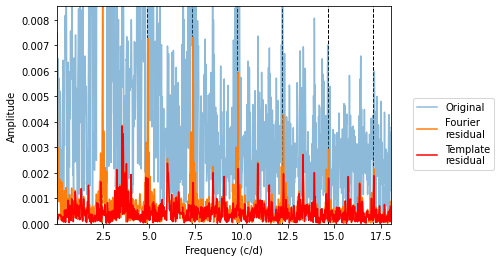

In [18]:
plt.plot(lsf,lsp,alpha=0.5,label='Original')
plt.plot(lsf,lsp_res,label='Fourier\nresidual')
plt.plot(lsf,lsp_template,'r',label='Template\nresidual')

plt.xlim(lsf.min(),lsf.max())
plt.ylim(0,lsp_res.max())

for ii in range(1,10):
    plt.axvline( ii*pfit[0], c='k',zorder=0,lw=1.,ls='--')
    
plt.xlabel('Frequency (c/d)')
plt.ylabel('Amplitude')
plt.legend(bbox_to_anchor=(1.05,0,0,0.6))
plt.show()